# G.SubtVision - Etapa 1
Tendo as tabelas com os resultados dos 10 folds de cada rede, mescla-se essas tabelas para assim obter o resultado do ensemble de cada rede. Esse ensemble é chamado de **Ensemble Single Arquiteture (SA)**

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import ast
import os

C:\Users\IA\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\IA\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1 -  Gerando tabelas mescladas por arquitetura

In [2]:
def load_and_rename(file_path, model_name, fold):
    # Carregar o arquivo CSV
    df = pd.read_csv(file_path)

    # Definir o sufixo com base no modelo e no fold
    suffix = f'_{model_name}{fold}'

    # Renomear as colunas de predição
    df.rename(columns={
        'predicted_label': f'predicted_label{suffix}',
        'predicted_probability': f'predicted_probability{suffix}',
        'probability_vector': f'probability_vector{suffix}',
        'probability_std_dev': f'probability_std_dev{suffix}'
    }, inplace=True)

    return df

In [3]:
def generate_merged_table(folders, model_names):
    # Etapa para carregar os arquivos e renomear as colunas
    all_data = []

    for model_name, folder in zip(model_names, folders):
        for fold in range(10):  # Para cada fold de 0 a 9
            # Caminho do arquivo (modifique o caminho conforme sua estrutura de pastas)
            file_path = f'{BASE_PATH}/{model_name}_fold{fold}_results.csv'  # Ajuste o caminho real
            if os.path.exists(file_path):
                # Carregar e renomear as colunas
                df_renamed = load_and_rename(file_path, folder, fold)
                all_data.append(df_renamed)
            else:
                print(f'Arquivo não encontrado: {file_path}')

    # ETAPA 2

    # Mesclar os arquivos pela chave 'image_path' e 'true_label'
    merged_df = all_data[0]
    for df in all_data[1:]:
        merged_df = merged_df.merge(df, on=['image_path', 'true_label', 'true_label_one_hot'], how='outer')
        
    return merged_df

### MobileNet V2

In [4]:
# Caminho das pastas
folders = ['m']  # Substitua pelos caminhos reais
model_names = ['0707-213643_MobileNetV2']
BASE_PATH = r'inputs/summary_results/'

merged_df_mob = generate_merged_table(folders, model_names)
# Salvando tabela mesclada
merged_df_mob.to_csv('outputs/merged_table_mob.csv', index=False)
print(f'Tabela mesclada salva! Com dimensões: {merged_df_mob.shape}')

Tabela mesclada salva! Com dimensões: (179952, 43)


### GoogleLeNet

In [5]:
# Caminho das pastas
folders = ['g']  # Substitua pelos caminhos reais
model_names = ['0710-161214_GoogleNet']
BASE_PATH = r'inputs/summary_results/'

merged_df_gg = generate_merged_table(folders, model_names)
# Salvando tabela mesclada
merged_df_gg.to_csv('outputs/merged_table_gg.csv', index=False)
print(f'Tabela mesclada salva! Com dimensões: {merged_df_gg.shape}')

Tabela mesclada salva! Com dimensões: (179952, 43)


### ShuffleNet

In [6]:
# Caminho das pastas
folders = ['s']  # Substitua pelos caminhos reais
model_names = ['0711-213955_ShuffleNetV2']
BASE_PATH = r'inputs/summary_results/'

merged_df_sh = generate_merged_table(folders, model_names)
# Salvando tabela mesclada
merged_df_sh.to_csv('outputs/merged_table_sh.csv', index=False)
print(f'Tabela mesclada salva! Com dimensões: {merged_df_sh.shape}')

Tabela mesclada salva! Com dimensões: (179952, 43)


### EffNet 2º Treinamento

In [7]:
# Caminho das pastas
folders = ['e2']  # Substitua pelos caminhos reais
model_names = ['0903-102424_EFF-NET']
BASE_PATH = r'inputs/summary_results/'

merged_df_eff2 = generate_merged_table(folders, model_names)
# Salvando tabela mesclada
merged_df_eff2.to_csv('outputs/merged_table_eff2.csv', index=False)
print(f'Tabela mesclada salva! Com dimensões: {merged_df_eff2.shape}')

Tabela mesclada salva! Com dimensões: (179952, 43)


## 2 - Gerando resultados por arquitetura

In [8]:
# Passo 1: Hard Voting
def hard_voting(df, model, network, print_flag=True):
    # Extrair as colunas de predicted_label
    cols_hard = [f'predicted_label_{model}{i}' for i in range(10)] 
    
    # Função para fazer a votação majoritária
    def get_majority_vote(row):
        votes = [row[col] for col in cols_hard]
        return max(set(votes), key=votes.count)
    
    # Aplicar a função para calcular a predição do Hard Voting
    df['hard_voting_label'] = df.apply(get_majority_vote, axis=1)
    
    if(print_flag):
        # Calcular as métricas (classificação)
        print(f"===== Hard Voting 10 folds nível de TILE - {network}=====")
        print(classification_report(df['true_label'], df['hard_voting_label']))
    
    return df

# Passo 2: Soft Voting
# Função para calcular a classe com maior probabilidade (Soft Voting) usando probability_vector
def soft_voting(df, model, network, classes, print_flag=True):
    # Extrair as colunas de probability_vector
    cols_soft = [f'probability_vector_{model}{i}' for i in range(10)]
    
    # Função para converter dicionário para vetor de probabilidades
    def dict_to_prob_vector(prob_dict, classes):
        # Transformar o dicionário de probabilidades para vetor ordenado
        return [prob_dict.get(cls, 0) for cls in classes]
    
    # Função para calcular a média das probabilidades
    def get_soft_vote(row):
        prob_vectors = [dict_to_prob_vector(ast.literal_eval(row[col]), classes) for col in cols_soft]
        prob_vectors = np.array(prob_vectors)  # Converter para um array numpy
        avg_probs = prob_vectors.mean(axis=0)  # Média das probabilidades para cada classe
        return avg_probs
    
    # Aplicar a função para calcular a probabilidade média
    df['soft_voting_probs'] = df.apply(get_soft_vote, axis=1)
    
    # Escolher a classe com maior probabilidade média
    df['soft_voting_label'] = df['soft_voting_probs'].apply(lambda x: classes[np.argmax(x)])
    
    if(print_flag):
        # Calcular as métricas (classificação)
        print(f"\n===== Soft Voting 10 folds nível de TILE - {network} =====")
        print(classification_report(df['true_label'], df['soft_voting_label']))
    
    return df
    

# Função para extrair o vetor de probabilidade de um dicionário
def dict_to_prob_vector(prob_dict, classes):
    return [prob_dict.get(cls, 0) for cls in classes]

# Função para calcular a média das probabilidades de todos os modelos e folds
def get_soft_voting_probs(row, model_prefixes, folds):
    prob_vectors = []
    
    # Iterar sobre os modelos e folds
    for model in model_prefixes:
        for fold in range(folds):
            # Construir o nome da coluna de probabilidade
            col_name = f'probability_vector_{model}{fold}'
            if col_name in row:
                prob_dict = ast.literal_eval(row[col_name])  # Extrair o dicionário
                prob_vector = dict_to_prob_vector(prob_dict, classes)  # Converter para vetor de probabilidade
                prob_vectors.append(prob_vector)
    
    # Calcular a média das probabilidades para cada classe
    prob_vectors = np.array(prob_vectors)
    avg_probs = prob_vectors.mean(axis=0)
    
    return avg_probs

# Função para obter o rótulo de Soft Voting
def get_soft_voting_label(row, model_prefixes, folds, classes):
    avg_probs = get_soft_voting_probs(row, model_prefixes, folds)
    return classes[np.argmax(avg_probs)]  # Classe com maior probabilidade média

In [9]:
def aggregate_to_image_level(df, classes):
    # extrair image_id do image_path
    df['image_id'] = df['image_path'].apply(lambda x: x.split('/')[-3].split('_files')[0])
    
    # função auxiliar para calcular o hard_voting_label por imagem
    def majority_vote(labels):
        return labels.value_counts().idxmax()
    
    def convert_to_array(probs):
        if isinstance(probs, str):
            # Remover colchetes e converter para array
            try:
                probs = probs.strip('[]')
                return np.array([float(x) for x in probs.split()])
            except:
                return np.array([0.0, 0.0, 0.0, 0.0])
        elif isinstance(probs, (list, np.ndarray)):
            return np.array(probs)
        else:
            return np.array([0.0, 0.0, 0.0, 0.0])
    
    # média dos vetores por imagem
    def mean_vec(series: pd.Series):
        return np.mean(np.vstack(series.values), axis=0)
    
    df['soft_voting_probs'] = df['soft_voting_probs'].apply(convert_to_array)

    # agregação por image_id
    agg_df = df.groupby('image_id').agg({
        'hard_voting_label': majority_vote,
        'soft_voting_probs': mean_vec,
        'true_label': 'first'   # pega o primeiro true_label da imagem
    }).reset_index()
    
    # calcular o soft_voting_label a partir do vetor médio
    agg_df['soft_voting_label'] = agg_df['soft_voting_probs'].apply(
        lambda probs: classes[np.argmax(probs)]
    )
    
    return agg_df[['image_id', 'true_label', 'hard_voting_label', 'soft_voting_probs', 'soft_voting_label']]

In [10]:
def evaluate_ensembles_image(agg_df, network):
    # Classification report para Hard Voting
    print(f"===== Hard Voting 10 folds nível de IMAGEM - {network} =====")
    print(classification_report(agg_df['true_label'], agg_df['hard_voting_label']))
    
    # Classification report para Soft Voting
    print(f"\n===== Soft Voting 10 folds nível de IMAGEM - {network} =====")
    print(classification_report(agg_df['true_label'], agg_df['soft_voting_label']))

In [11]:
def aggregate_to_patient_level(df,classes):
    # extrair image_id do image_path

    df['patient_id'] = df['image_path'].apply(lambda x: x.split('/')[-3].split('_files')[0][:12])
    
    # função auxiliar para calcular o hard_voting_label por imagem
    def majority_vote(labels):
        return labels.value_counts().idxmax()
    
    def convert_to_array(probs):
        if isinstance(probs, str):
            # Remover colchetes e converter para array
            try:
                probs = probs.strip('[]')
                return np.array([float(x) for x in probs.split()])
            except:
                return np.array([0.0, 0.0, 0.0, 0.0])
        elif isinstance(probs, (list, np.ndarray)):
            return np.array(probs)
        else:
            return np.array([0.0, 0.0, 0.0, 0.0])
    
    # média dos vetores por imagem
    def mean_vec(series: pd.Series):
        return np.mean(np.vstack(series.values), axis=0)
    
    df['soft_voting_probs'] = df['soft_voting_probs'].apply(convert_to_array)

    # agregação por image_id
    agg_df = df.groupby('patient_id').agg({
        'hard_voting_label': majority_vote,
        'soft_voting_probs': mean_vec,
        'true_label': 'first'   # pega o primeiro true_label da imagem
    }).reset_index()
    
    # calcular o soft_voting_label a partir do vetor médio
    agg_df['soft_voting_label'] = agg_df['soft_voting_probs'].apply(
        lambda probs: classes[np.argmax(probs)]
    )
    
    return agg_df[['patient_id', 'true_label', 'hard_voting_label', 'soft_voting_probs', 'soft_voting_label']]

In [12]:
def evaluate_ensembles_patient(agg_df, network):
    # Classification report para Hard Voting
    print(f"===== Hard Voting 10 folds nível de PATIENT - {network} =====")
    print(classification_report(agg_df['true_label'], agg_df['hard_voting_label']))
    
    # Classification report para Soft Voting
    print(f"\n===== Soft Voting 10 folds nível de PATIENT - {network} =====")
    print(classification_report(agg_df['true_label'], agg_df['soft_voting_label']))

In [13]:
def convert_to_array(probs):
        if isinstance(probs, str):
            # Remover colchetes e converter para array
            try:
                probs = probs.strip('[]')
                return np.array([float(x) for x in probs.split()])
            except:
                return np.array([0.0, 0.0, 0.0, 0.0])
        elif isinstance(probs, (list, np.ndarray)):
            return np.array(probs)
        else:
            return np.array([0.0, 0.0, 0.0, 0.0])

In [14]:
def plot_sodt_roc_curve(df, level, fig_name, file_name, classes):    
    # Binarizar os rótulos verdadeiros (true_label) para o cálculo da curva ROC
    y_true = label_binarize(df['true_label'], classes=classes)

    # Soft Voting: Convertendo as probabilidades para matriz
    y_pred_soft = np.vstack(df['soft_voting_probs'].apply(convert_to_array).values)


    # Preparando o gráfico
    plt.figure(figsize=(10, 8))

    # Loop sobre cada classe para gerar a curva ROC
    roc_auc = {}
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_soft[:, i])
        roc_auc[cls] = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Classe {cls} (AUC = {roc_auc[cls]:.2f})')

    # Calcular o micro-average ROC
    # fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_pred_soft.ravel())
    # roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Calcular micro-average ROC curve e AUC
    fpr_macro, tpr_macro, _ = roc_curve(y_true.ravel(), y_pred_soft.ravel())
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plotar a curva ROC para o micro-average
    plt.plot(fpr_macro, tpr_macro, color='purple', linestyle='--', lw=2, label=f'Macro-average (AUC = {roc_auc_macro:.2f})')

    # Plotar linha de aleatoriedade
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Definir títulos e rótulos
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title(fig_name)
    plt.legend(loc='lower right')
    plt.grid(True)

    # Exibir o gráfico
    plt.tight_layout()
    save_output = "outputs/auc_roc_sa_plots/"
    plt.savefig(os.path.join(save_output, file_name))
    plt.show()

### MobileNet V2

In [15]:
classes = ['cin', 'ebv', 'gs', 'msi']

# Carregar seu DataFrame
df_mob = merged_df_mob.copy()

network = 'MobileNetV2'
model = 'm'

# Calcular as métricas para Hard Voting
df_mob = hard_voting(df_mob, model, network)
# Calcular as métricas para Soft Voting
df_mob = soft_voting(df_mob, model, network, classes)

===== Hard Voting 10 folds nível de TILE - MobileNetV2=====
              precision    recall  f1-score   support

         cin       0.63      0.75      0.68     89707
         ebv       0.59      0.31      0.40     25081
          gs       0.29      0.46      0.36     27191
         msi       0.66      0.29      0.40     37973

    accuracy                           0.55    179952
   macro avg       0.54      0.45      0.46    179952
weighted avg       0.58      0.55      0.54    179952


===== Soft Voting 10 folds nível de TILE - MobileNetV2 =====
              precision    recall  f1-score   support

         cin       0.62      0.78      0.69     89707
         ebv       0.61      0.30      0.40     25081
          gs       0.31      0.43      0.36     27191
         msi       0.65      0.31      0.42     37973

    accuracy                           0.56    179952
   macro avg       0.55      0.46      0.47    179952
weighted avg       0.58      0.56      0.54    179952



In [16]:
agg_image_mob_df = aggregate_to_image_level(df_mob, classes)
print(f"Quantidade de imagem: {len(agg_image_mob_df['image_id'].value_counts())}")
evaluate_ensembles_image(agg_image_mob_df, network)

Quantidade de imagem: 96
===== Hard Voting 10 folds nível de IMAGEM - MobileNetV2 =====
              precision    recall  f1-score   support

         cin       0.56      0.94      0.70        47
         ebv       1.00      0.18      0.31        11
          gs       0.50      0.40      0.44        15
         msi       1.00      0.13      0.23        23

    accuracy                           0.57        96
   macro avg       0.76      0.41      0.42        96
weighted avg       0.70      0.57      0.50        96


===== Soft Voting 10 folds nível de IMAGEM - MobileNetV2 =====
              precision    recall  f1-score   support

         cin       0.54      0.94      0.68        47
         ebv       1.00      0.18      0.31        11
          gs       0.56      0.33      0.42        15
         msi       1.00      0.13      0.23        23

    accuracy                           0.56        96
   macro avg       0.77      0.40      0.41        96
weighted avg       0.70      0.56

In [17]:
agg_patient_mob_df = aggregate_to_patient_level(df_mob, classes)
print(f"Quantidade de imagem: {len(agg_patient_mob_df['patient_id'].value_counts())}")
evaluate_ensembles_patient(agg_patient_mob_df, network)

Quantidade de imagem: 82
===== Hard Voting 10 folds nível de PATIENT - MobileNetV2 =====
              precision    recall  f1-score   support

         cin       0.58      0.95      0.72        41
         ebv       1.00      0.20      0.33        10
          gs       0.50      0.38      0.43        13
         msi       1.00      0.17      0.29        18

    accuracy                           0.60        82
   macro avg       0.77      0.43      0.44        82
weighted avg       0.71      0.60      0.53        82


===== Soft Voting 10 folds nível de PATIENT - MobileNetV2 =====
              precision    recall  f1-score   support

         cin       0.57      0.95      0.71        41
         ebv       1.00      0.10      0.18        10
          gs       0.62      0.38      0.48        13
         msi       0.75      0.17      0.27        18

    accuracy                           0.59        82
   macro avg       0.74      0.40      0.41        82
weighted avg       0.67      0.

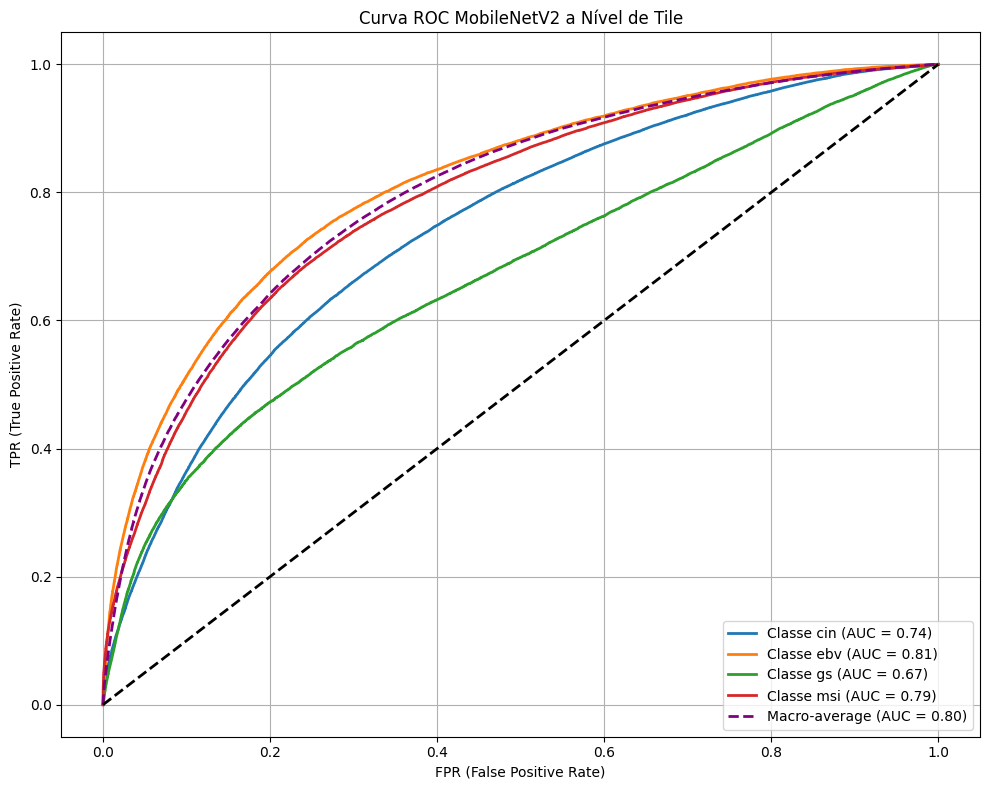

In [18]:
fig_name = 'Curva ROC MobileNetV2 a Nível de Tile'
file_name = 'roc_soft_mob_tile.png'
plot_sodt_roc_curve(df_mob, "Tile", fig_name, file_name, classes)

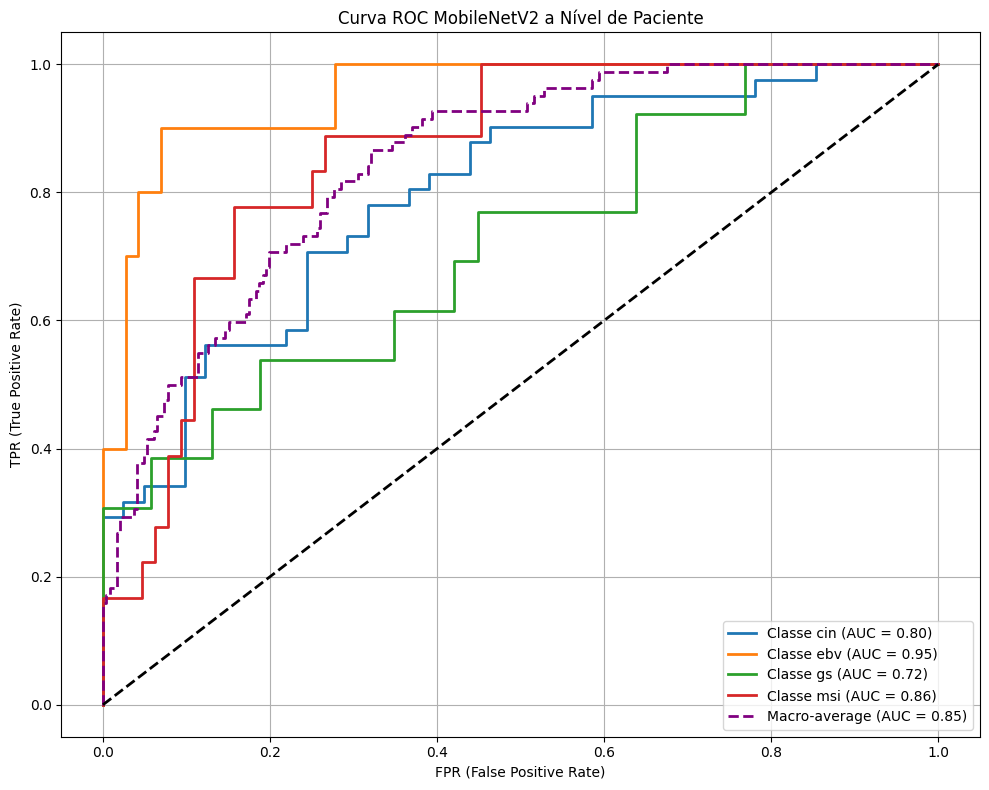

In [19]:
agg_patient_mob_df = aggregate_to_patient_level(df_mob, classes)
fig_name = 'Curva ROC MobileNetV2 a Nível de Paciente'
file_name = 'roc_soft_mob_patient.png'
plot_sodt_roc_curve(agg_patient_mob_df, "Paciente", fig_name, file_name, classes)

### GoogleLeNet

In [20]:
classes = ['cin', 'ebv', 'gs', 'msi']

# Carregar seu DataFrame
df_gg = merged_df_gg.copy()

network = 'GoogleNet'
model = 'g'

# Calcular as métricas para Hard Voting
df_gg = hard_voting(df_gg, model, network)
# Calcular as métricas para Soft Voting
df_gg = soft_voting(df_gg, model, network, classes)

===== Hard Voting 10 folds nível de TILE - GoogleNet=====
              precision    recall  f1-score   support

         cin       0.63      0.72      0.67     89707
         ebv       0.40      0.42      0.41     25081
          gs       0.34      0.46      0.39     27191
         msi       0.52      0.19      0.28     37973

    accuracy                           0.53    179952
   macro avg       0.47      0.45      0.44    179952
weighted avg       0.53      0.53      0.51    179952


===== Soft Voting 10 folds nível de TILE - GoogleNet =====
              precision    recall  f1-score   support

         cin       0.64      0.74      0.68     89707
         ebv       0.40      0.44      0.42     25081
          gs       0.36      0.43      0.40     27191
         msi       0.53      0.23      0.32     37973

    accuracy                           0.54    179952
   macro avg       0.48      0.46      0.45    179952
weighted avg       0.54      0.54      0.53    179952



In [21]:
agg_image_gg_df = aggregate_to_image_level(df_gg, classes)
print(f"Quantidade de imagem: {len(agg_image_gg_df['image_id'].value_counts())}")
evaluate_ensembles_image(agg_image_gg_df, network)

Quantidade de imagem: 96
===== Hard Voting 10 folds nível de IMAGEM - GoogleNet =====
              precision    recall  f1-score   support

         cin       0.53      0.89      0.67        47
         ebv       0.50      0.27      0.35        11
          gs       0.50      0.33      0.40        15
         msi       1.00      0.04      0.08        23

    accuracy                           0.53        96
   macro avg       0.63      0.39      0.38        96
weighted avg       0.64      0.53      0.45        96


===== Soft Voting 10 folds nível de IMAGEM - GoogleNet =====
              precision    recall  f1-score   support

         cin       0.55      0.89      0.68        47
         ebv       0.60      0.27      0.38        11
          gs       0.56      0.33      0.42        15
         msi       0.60      0.13      0.21        23

    accuracy                           0.55        96
   macro avg       0.58      0.41      0.42        96
weighted avg       0.57      0.55    

In [22]:
agg_patient_gg_df = aggregate_to_patient_level(df_gg, classes)
print(f"Quantidade de imagem: {len(agg_patient_gg_df['patient_id'].value_counts())}")
evaluate_ensembles_patient(agg_patient_gg_df, network)

Quantidade de imagem: 82
===== Hard Voting 10 folds nível de PATIENT - GoogleNet =====
              precision    recall  f1-score   support

         cin       0.56      0.93      0.70        41
         ebv       0.40      0.20      0.27        10
          gs       0.71      0.38      0.50        13
         msi       0.50      0.06      0.10        18

    accuracy                           0.56        82
   macro avg       0.54      0.39      0.39        82
weighted avg       0.55      0.56      0.48        82


===== Soft Voting 10 folds nível de PATIENT - GoogleNet =====
              precision    recall  f1-score   support

         cin       0.56      0.93      0.70        41
         ebv       0.60      0.30      0.40        10
          gs       0.71      0.38      0.50        13
         msi       0.50      0.06      0.10        18

    accuracy                           0.57        82
   macro avg       0.59      0.42      0.42        82
weighted avg       0.58      0.57  

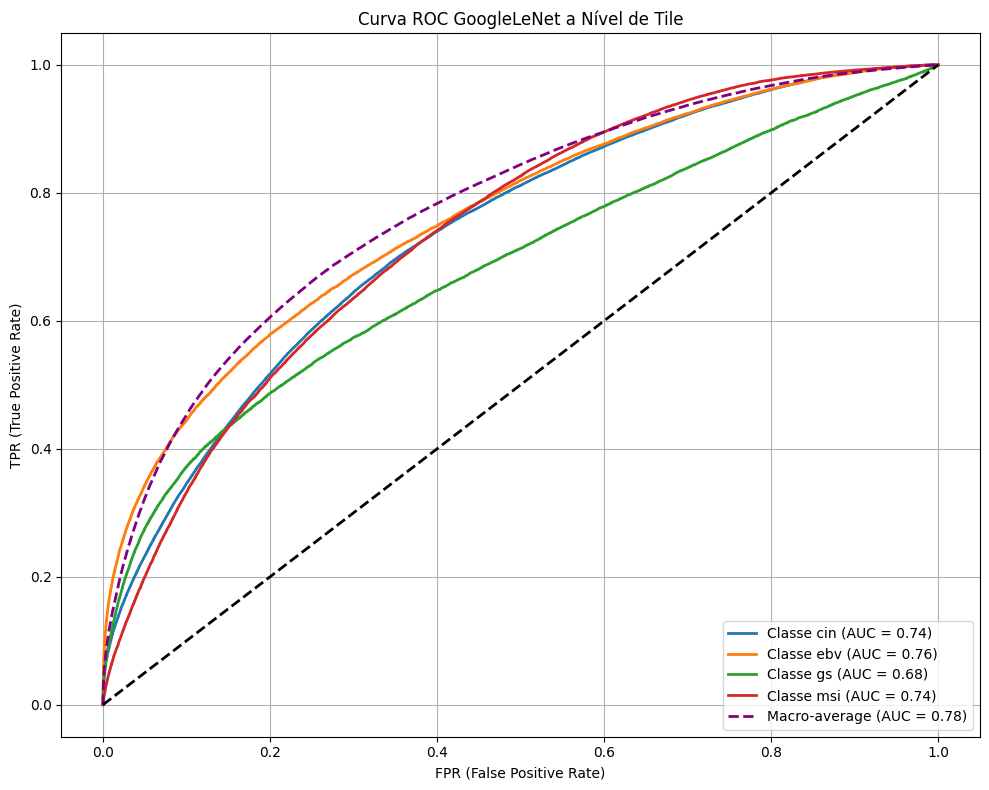

In [23]:
fig_name = 'Curva ROC GoogleLeNet a Nível de Tile'
file_name = 'roc_soft_gg_tile.png'
plot_sodt_roc_curve(df_gg, "Tile", fig_name, file_name, classes)

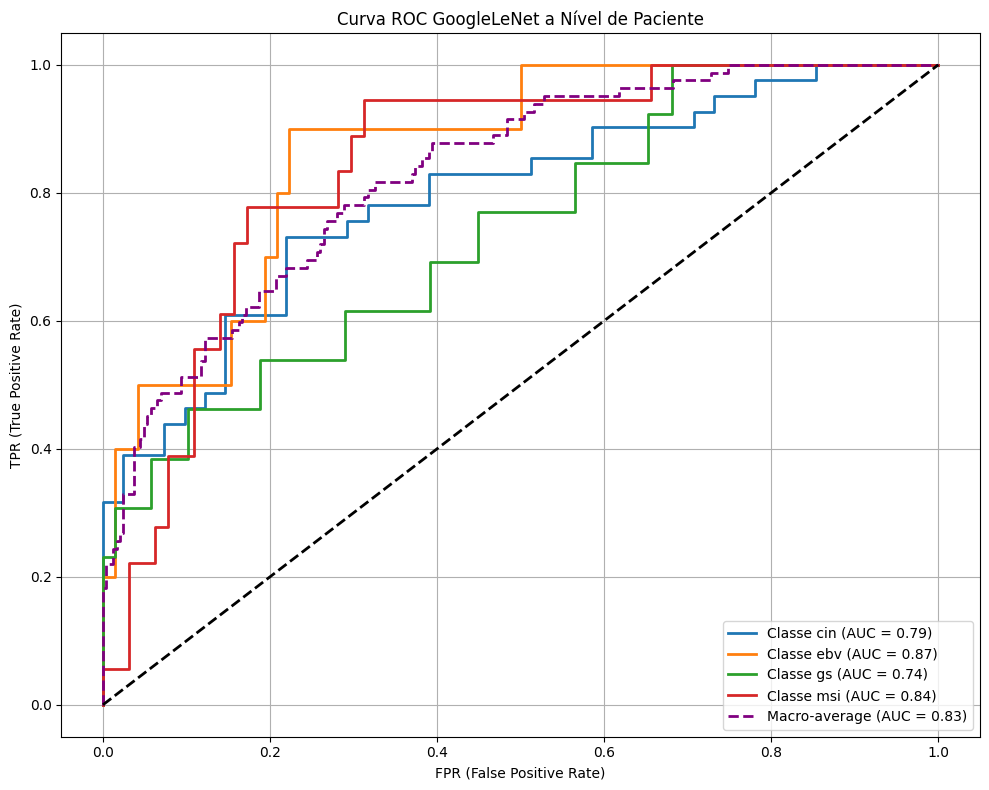

In [24]:
agg_patient_gg_df = aggregate_to_patient_level(df_gg, classes)
fig_name = 'Curva ROC GoogleLeNet a Nível de Paciente'
file_name = 'roc_soft_gg_patient.png'
plot_sodt_roc_curve(agg_patient_gg_df, "Paciente", fig_name, file_name, classes)

### ShuffleNet

In [25]:
classes = ['cin', 'ebv', 'gs', 'msi']

# Carregar seu DataFrame
df_sh = merged_df_sh.copy()

network = 'ShuffleNet'
model = 's'

# Calcular as métricas para Hard Voting
df_sh = hard_voting(df_sh, model, network)
# Calcular as métricas para Soft Voting
df_sh = soft_voting(df_sh, model, network, classes)

===== Hard Voting 10 folds nível de TILE - ShuffleNet=====
              precision    recall  f1-score   support

         cin       0.61      0.81      0.69     89707
         ebv       0.63      0.37      0.46     25081
          gs       0.25      0.27      0.26     27191
         msi       0.63      0.28      0.39     37973

    accuracy                           0.55    179952
   macro avg       0.53      0.43      0.45    179952
weighted avg       0.56      0.55      0.53    179952


===== Soft Voting 10 folds nível de TILE - ShuffleNet =====
              precision    recall  f1-score   support

         cin       0.61      0.81      0.70     89707
         ebv       0.62      0.40      0.48     25081
          gs       0.26      0.25      0.25     27191
         msi       0.62      0.32      0.42     37973

    accuracy                           0.56    179952
   macro avg       0.53      0.44      0.46    179952
weighted avg       0.56      0.56      0.54    179952



In [26]:
agg_image_sh_df = aggregate_to_image_level(df_sh,classes)
print(f"Quantidade de imagem: {len(agg_image_sh_df['image_id'].value_counts())}")
evaluate_ensembles_image(agg_image_sh_df, network)

Quantidade de imagem: 96
===== Hard Voting 10 folds nível de IMAGEM - ShuffleNet =====
              precision    recall  f1-score   support

         cin       0.57      0.96      0.71        47
         ebv       1.00      0.27      0.43        11
          gs       0.38      0.20      0.26        15
         msi       0.83      0.22      0.34        23

    accuracy                           0.58        96
   macro avg       0.69      0.41      0.44        96
weighted avg       0.65      0.58      0.52        96


===== Soft Voting 10 folds nível de IMAGEM - ShuffleNet =====
              precision    recall  f1-score   support

         cin       0.56      0.96      0.71        47
         ebv       1.00      0.18      0.31        11
          gs       0.43      0.20      0.27        15
         msi       0.86      0.26      0.40        23

    accuracy                           0.58        96
   macro avg       0.71      0.40      0.42        96
weighted avg       0.66      0.58  

In [27]:
agg_patient_sh_df = aggregate_to_patient_level(df_sh, classes)
print(f"Quantidade de pacientes: {len(agg_patient_sh_df['patient_id'].value_counts())}")
evaluate_ensembles_patient(agg_patient_sh_df, network)

Quantidade de pacientes: 82
===== Hard Voting 10 folds nível de PATIENT - ShuffleNet =====
              precision    recall  f1-score   support

         cin       0.59      0.98      0.73        41
         ebv       1.00      0.30      0.46        10
          gs       0.50      0.23      0.32        13
         msi       0.80      0.22      0.35        18

    accuracy                           0.61        82
   macro avg       0.72      0.43      0.46        82
weighted avg       0.67      0.61      0.55        82


===== Soft Voting 10 folds nível de PATIENT - ShuffleNet =====
              precision    recall  f1-score   support

         cin       0.58      0.98      0.73        41
         ebv       1.00      0.20      0.33        10
          gs       0.50      0.23      0.32        13
         msi       0.80      0.22      0.35        18

    accuracy                           0.60        82
   macro avg       0.72      0.41      0.43        82
weighted avg       0.67      0

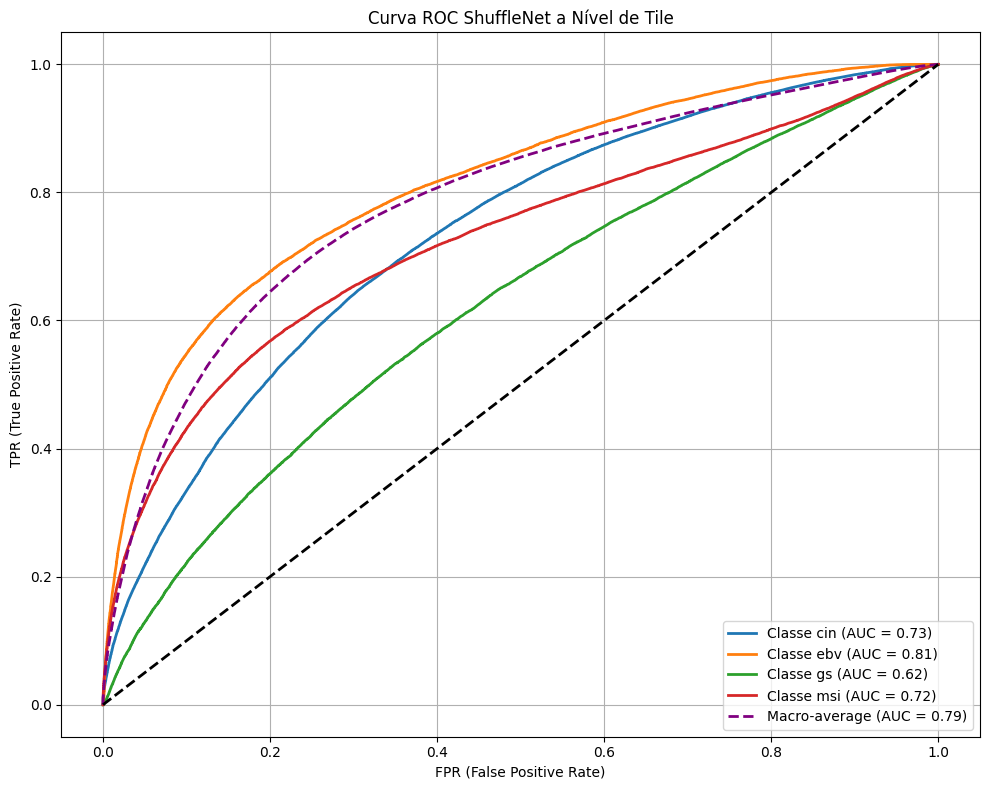

In [28]:
fig_name = 'Curva ROC ShuffleNet a Nível de Tile'
file_name = 'roc_soft_sh_tile.png'
plot_sodt_roc_curve(df_sh, "Tile", fig_name, file_name, classes)

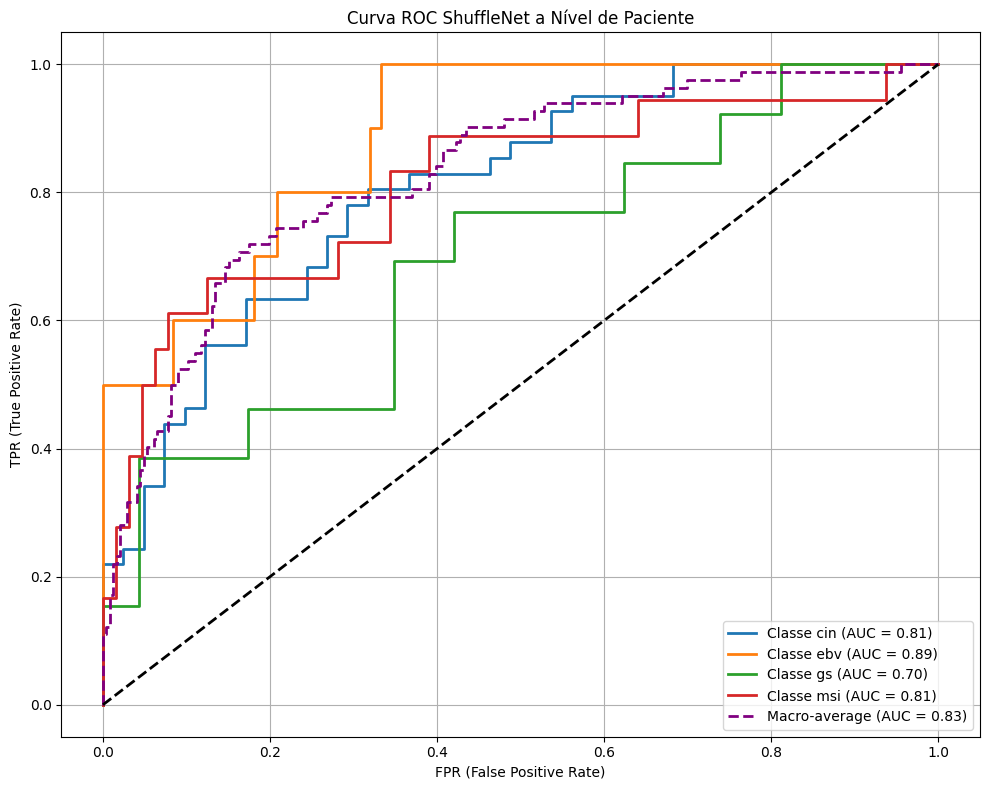

In [29]:
agg_patient_sh_df = aggregate_to_patient_level(df_sh, classes)
fig_name = 'Curva ROC ShuffleNet a Nível de Paciente'
file_name = 'roc_soft_sh_patient.png'
plot_sodt_roc_curve(agg_patient_sh_df, "Paciente", fig_name, file_name, classes)

### EffNet 2º Treinamento

In [30]:
classes = ['cin', 'ebv', 'gs', 'msi']

# Carregar seu DataFrame
df_eff2 = merged_df_eff2.copy()

network = 'EfficientNet'
model = 'e2'

# Calcular as métricas para Hard Voting
df_eff2 = hard_voting(df_eff2, model, network)
# Calcular as métricas para Soft Voting
df_eff2 = soft_voting(df_eff2, model, network, classes)

===== Hard Voting 10 folds nível de TILE - EfficientNet=====
              precision    recall  f1-score   support

         cin       0.60      0.84      0.70     89707
         ebv       0.54      0.37      0.44     25081
          gs       0.41      0.25      0.31     27191
         msi       0.51      0.27      0.35     37973

    accuracy                           0.57    179952
   macro avg       0.51      0.43      0.45    179952
weighted avg       0.54      0.57      0.53    179952


===== Soft Voting 10 folds nível de TILE - EfficientNet =====
              precision    recall  f1-score   support

         cin       0.61      0.84      0.71     89707
         ebv       0.56      0.35      0.43     25081
          gs       0.42      0.24      0.31     27191
         msi       0.51      0.33      0.40     37973

    accuracy                           0.57    179952
   macro avg       0.52      0.44      0.46    179952
weighted avg       0.55      0.57      0.54    179952



In [31]:
agg_image_eff2_df = aggregate_to_image_level(df_eff2, classes)
print(f"Quantidade de imagem: {len(agg_image_eff2_df['image_id'].value_counts())}")
evaluate_ensembles_image(agg_image_eff2_df, network)

Quantidade de imagem: 96
===== Hard Voting 10 folds nível de IMAGEM - EfficientNet =====
              precision    recall  f1-score   support

         cin       0.54      0.98      0.70        47
         ebv       1.00      0.27      0.43        11
          gs       1.00      0.13      0.24        15
         msi       0.50      0.13      0.21        23

    accuracy                           0.56        96
   macro avg       0.76      0.38      0.39        96
weighted avg       0.66      0.56      0.48        96


===== Soft Voting 10 folds nível de IMAGEM - EfficientNet =====
              precision    recall  f1-score   support

         cin       0.55      0.98      0.70        47
         ebv       1.00      0.27      0.43        11
          gs       1.00      0.13      0.24        15
         msi       0.57      0.17      0.27        23

    accuracy                           0.57        96
   macro avg       0.78      0.39      0.41        96
weighted avg       0.68      0.

In [32]:
agg_patient_eff2_df = aggregate_to_patient_level(df_eff2, classes)
print(f"Quantidade de pacientes: {len(agg_patient_eff2_df['patient_id'].value_counts())}")
evaluate_ensembles_patient(agg_patient_eff2_df, network)

Quantidade de pacientes: 82
===== Hard Voting 10 folds nível de PATIENT - EfficientNet =====
              precision    recall  f1-score   support

         cin       0.54      0.98      0.70        41
         ebv       1.00      0.30      0.46        10
          gs       1.00      0.15      0.27        13
         msi       0.33      0.06      0.10        18

    accuracy                           0.56        82
   macro avg       0.72      0.37      0.38        82
weighted avg       0.62      0.56      0.47        82


===== Soft Voting 10 folds nível de PATIENT - EfficientNet =====
              precision    recall  f1-score   support

         cin       0.56      0.98      0.71        41
         ebv       1.00      0.30      0.46        10
          gs       1.00      0.15      0.27        13
         msi       0.60      0.17      0.26        18

    accuracy                           0.59        82
   macro avg       0.79      0.40      0.42        82
weighted avg       0.69   

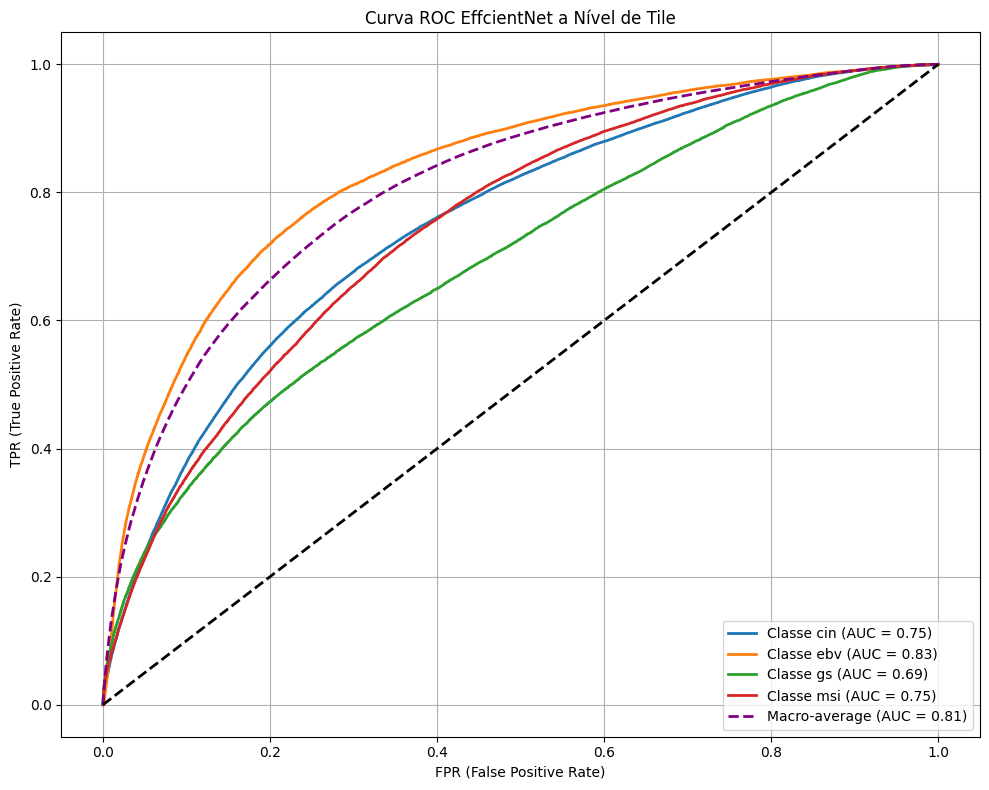

In [33]:
fig_name = 'Curva ROC EffcientNet a Nível de Tile'
file_name = 'roc_soft_eff2_tile.png'
plot_sodt_roc_curve(df_eff2, "Tile", fig_name, file_name, classes)

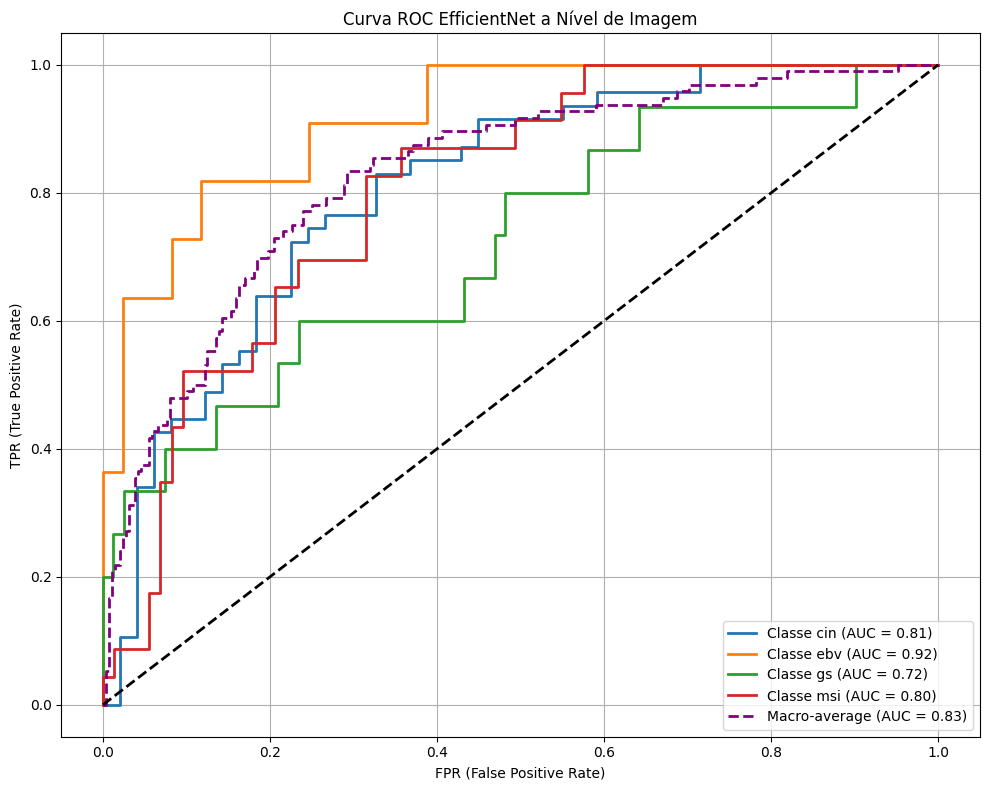

In [34]:
agg_image_eff2_df = aggregate_to_image_level(df_eff2, classes)
fig_name = 'Curva ROC EfficientNet a Nível de Imagem'
file_name = 'roc_soft_eff2_image.png'
plot_sodt_roc_curve(agg_image_eff2_df, "Paciente", fig_name, file_name, classes)